In [1]:
"""
Notebook utilizado para apresentar uma introdução à teoria da amostragem de sinais.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.

Protegido por licença GPL v3.0. O uso e a reprodução são livres para fins educacionais
desde que citada a fonte.

Prof. Dr. Emerson Rodrigo Almeida
emerson.almeida@ufu.br

Última modificação: 05/02/2021
"""

'\nNotebook utilizado para apresentar uma introdução à teoria da amostragem de sinais.\nCriado para a disciplina Geofísica I da Universidade Federal de Uberlândia.\n\nProtegido por licença GPL v3.0. O uso e a reprodução são livres para fins educacionais\ndesde que citada a fonte.\n\nProf. Dr. Emerson Rodrigo Almeida\nemerson.almeida@ufu.br\n\nÚltima modificação: 05/02/2021\n'

# Instruções iniciais


### Chegamos a um ponto extremamente importante! É fundamental que você compreenda o que está sendo abordado aqui, pois o conceito de filtragem é utilizado em TODOS os métodos geofísicos.

Neste notebook você irá aprender como funciona a filtragem de frequências indesejadas em sinais. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

### Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula**. Você pode executar o código na célula clicando no botão RUN na barra do Jupyter Notebook ou pressionando as teclas SHIFT+ENTER no seu teclado.

In [2]:
from scipy.fftpack import fft, fftfreq, ifft
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# funções dos cálculos

def gera_sinal(a, f, t_max):
    """
    Gera uma função obtida a partir de uma sobreposição de funções seno, onde cada uma delas é caracterizada por
    uma amplitude A e frequência f na forma s(t) = A * cos(2 * pi * f * t). A sobreposição destas funções será o sinal
    analógico de referência. Esta função pode ser amostrada em qualquer instante de tempo que se queira, de forma 
    que esta é a melhor forma de representar um sinal contínuo para os objetivos desta demonstração.
    """
    
    dt = t_max/1000
    tt = np.arange(0, t_max + dt, dt)                        # eixo de tempo estendido
    
    s = np.zeros(np.shape(tt))
    
    for i in range(len(a)):
        s = s + (a[i] * np.sin(2 * np.pi * f[i] * tt))
        
    ruido = np.random.normal(loc=0.0, scale=1, size=tt.shape)   # ruído branco para estabilizar a filtragem
    
    return s, tt      # função que caracteriza o sinal analógico



def calcula_espectro(tt, ss):
    
    dt = tt[1] - tt[0]
    n_amostras = len(ss)

    espectro = fft(ss, axis=0)
    ff = fftfreq(len(ss), dt)
    
    return ff, espectro


def gera_filtro(f_c, forma):
    df = frequencias[1] - frequencias[0]
    i_max_freq = np.abs(frequencias-np.max(frequencias)).argmin()   # indice da máxima frequência positiva
    delta_rampa = 3*df

    # ajusta a caixa das palavras e troca a separação para um traço ao invés de um espaço
    forma = forma.lower()
    if forma in ['passa baixa', 'passa alta', 'passa banda', 'rejeita banda']:
        forma = '-'.join(forma.split(' '))
    
    if forma=='passa-baixa':
        amp_caixa = [1, 1, 0, 0]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa = f_c[0] + delta_rampa        # frequência no fim da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_c[0], f_rampa, np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='passa-alta':
        amp_caixa = [0, 0, 1, 1]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa = f_c[0] - delta_rampa        # frequência no início da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_rampa, f_c[0], np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='passa-banda':
        amp_caixa = [0, 0, 1, 1, 0, 0]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa_sub = f_c[0] - delta_rampa        # frequência no início da rampa do filtro
        f_rampa_desc = f_c[1] + delta_rampa        # frequência no fim da rampa do filtro
        f_rampa_sub, f_rampa_desc, f_c = verifica_rampas(f_rampa_sub, f_rampa_desc, f_c, frequencias)
        f_caixa_pos = np.array([frequencias[0], f_rampa_sub, f_c[0], f_c[1], f_rampa_desc, np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='rejeita-banda':
        amp_caixa = [1, 1, 0, 0, 1, 1]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa_desc = f_c[0] - delta_rampa        # frequência no fim da rampa do filtro
        f_rampa_sub = f_c[1] + delta_rampa        # frequência no inicio da rampa do filtro
        f_rampa_desc, f_rampa_sub, f_c = verifica_rampas(f_rampa_desc, f_rampa_sub, f_c, frequencias)
        f_caixa_pos = np.array([frequencias[0], f_rampa_desc, f_c[0], f_c[1], f_rampa_sub, np.max(frequencias)]) # caixa para a parte positiva do espectro

    # espelhamnto da caixa na parte positiva do espectro
    f_caixa_neg = np.flip(-1 * f_caixa_pos)   # caixa para a parte negativa do espectro
    f_caixa_neg[-1] = frequencias[-1]
    f_caixa_neg[0] = frequencias[i_max_freq+1]

    # interpolação das funções caixa para as frequências do espectro
    caixa_pos = interp1d(f_caixa_pos, amp_caixa, kind='linear')
    caixa_neg = interp1d(f_caixa_neg, np.flip(amp_caixa), kind='linear')

    return np.concatenate([caixa_pos(frequencias[:i_max_freq+1]), caixa_neg(frequencias[i_max_freq+1:])], axis=0)


def verifica_rampas(f_rampa1, f_rampa2, f_c, ff):
    """
    Verifica se as rampas do filtro passa-banda e rejeita-banda estão dentro dos limites do espectro.
    Não funciona para passa-alta e passa-baixa porque como só precisa de uma frequência de corte não 
    faz sentido estabelecer esta frequência próximo dos limites do espectro.
    """
        
    # para evitar pegar frequências negativas no limite da rampa
    if f_rampa1 < 0:                          
        f_c[0] = f_c[0] - f_rampa1    # desloca a frequêcia de corte para cima no eixo de frequências
        f_rampa1 = ff[0]              # define o início da rampa na frequência inicial do espectro

    # para evitar pegar frequências acima da frequência máxima do espectro no limite da rampa
    if f_rampa2 > np.max(ff):    
        f_c[1] = np.max(frequencias) - 3*(ff[1] - ff[0])   # desloca a frequêcia de corte para baixo no eixo de frequências
        f_rampa2 = np.max(frequencias)    # define o início da rampa na maior frequência positiva do espectro

    return f_rampa1, f_rampa2, f_c


def executa_filtragem(espec, f_c, forma):
    filtro = gera_filtro(f_c, forma)
    amp_filtrada = espec * filtro
    
    return np.real(ifft(amp_filtrada))


# funções das figuras

def ajusta_escala_tempo(tt):
    
    """
    Ajusta a escala de tempo a ser plotada nas figuras para não precisar mostrar os valores em notação científica.
    """
    
    if np.max(tt) < 1e-6 and np.max(tt) >= 1e-9:
        tt = tt * 1e9
        titulo_eixo_t = "Tempo (ns)"
    elif np.max(tt) < 1e-3 and np.max(tt) >= 1e-6:
        tt = tt * 1e6
        titulo_eixo_t = "Tempo ($\mu$s)"
    elif np.max(tt) < 1 and np.max(tt) >= 1e-3:
        tt = tt * 1e3
        titulo_eixo_t = "Tempo (ms)"
    else:
        titulo_eixo_t = "Tempo (s)"

    return tt, titulo_eixo_t



def ajusta_escala_frequencia(ff):
    """
    Ajusta a escala de tempo a ser plotada nas figuras para não precisar mostrar os valores em notação científica.
    """
    
    if np.max(ff) >= 1e9 and np.max(ff) < 1e12:
        ff = ff * 1e-9
        titulo_eixo_f = "Frequência (GHz)"
    elif np.max(ff) >= 1e6 and np.max(ff) < 1e9:
        ff = ff * 1e-6
        titulo_eixo_f = "Frequência (MHz)"
    elif np.max(ff) >= 1e3 and np.max(ff) < 1:
        ff = ff * 1e-3
        titulo_eixo_f = "Frequência (kHz)"
    else:
        titulo_eixo_f = "Frequência (Hz)"

    return ff, titulo_eixo_f



def plota_sinal(tt, ss, n_figura='X'):
    """
    Plota o sinal calculado pela sobreposição das funções seno.
    """
    
    tt, rotulo_x = ajusta_escala_tempo(tt)
    
    fig, ax = plt.subplots(figsize=(15,3))
    ax.plot(tt, ss)
    ax.set_xlabel(rotulo_x, fontsize=14)
    ax.set_ylabel("Amplitude (ua)", fontsize=14)
    ax.set_title("Figura " + n_figura + ". Sinal Original", fontsize=14)
    ax.set_xlim([tt[0], tt[-1]])
    ax.grid()

    
def plota_espectro(ff, espec, n_figura='X'):
    n_samples = len(espec)       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais

    nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
    amplitudes = (2 / n_samples) * np.abs(espec[:nf_positivas])
    frequencias = ff[:nf_positivas]
    
    frequencias, rotulo_x = ajusta_escala_frequencia(frequencias)
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stem(frequencias, amplitudes)
    ax.set_xlabel(rotulo_x, fontsize=14)
    ax.set_ylabel('Amplitude (ua)', fontsize=14)
    ax.set_xlim([0, np.max(frequencias)])
    ax.set_ylim([0, np.max(amplitudes)*1.25])
    ax.set_title("Figura " + n_figura + ". Espectro de amplitudes do sinal sintético original", fontsize=14)
    # ax.set_xticks(np.arange(0, frequencias[-1], 2))
    ax.grid()
    
    
def plota_filtragem(espec, ff, f_c, forma, n_figura='X'):
    """
    Apenas plota a representação da seleção de frequências com o filtro sobre a parte
    positiva do espectro, porém não executa a filtragem propriamente dita    
    """
    
    n_samples = len(espec)       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais
    nf_positivas = round(n_samples / 2)     # número de frequências positivas
    amplitudes = (2 / n_samples) * np.abs(espec[:nf_positivas])   # amplitudes das frequências positivas
    ff = frequencias[:nf_positivas]

    filtro = gera_filtro(f_c, forma)
    escala_filtro = np.max(amplitudes) + 0.10 * np.max(amplitudes)   # escala gráfica para plotar o contorno do filtro

    ff, rotulo_x = ajusta_escala_frequencia(ff)    
    
    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(13,7))
    ax[0].stem(ff, amplitudes)
    ax[0].plot(ff, filtro[:nf_positivas] * escala_filtro, '--r')
    ax[0].set_xlabel(rotulo_x, fontsize=14)
    ax[0].set_ylabel('Amplitude (ua)', fontsize=14)
    ax[0].set_xlim([0, np.max(ff)])
    ax[0].set_ylim([0, np.max(amplitudes)*1.25])
    ax[0].set_title("Figura " + n_figura + "a. Filtro " + tipo + " sobre o espectro", fontsize=14)
    #ax[0].set_xticks(np.arange(0, ff[-1], 2))
    ax[0].grid()

    ax[1].stem(ff, amplitudes * filtro[:nf_positivas])
    ax[1].set_xlabel(rotulo_x, fontsize=14)
    ax[1].set_ylabel('Amplitude (ua)', fontsize=14)
    ax[1].set_xlim([0, np.max(ff)])
    ax[1].set_ylim([0, np.max(amplitudes)*1.25])
    ax[1].set_title("Figura " + n_figura + "b. Frequências remanescentes após a filtragem", fontsize=14)
    #ax[1].set_xticks(np.arange(0, ff[-1], 2))
    ax[1].grid()

    plt.tight_layout()
    
    
def plota_gabarito(tt, s_filtrado, s_limpo, n_figura='X'):

    tt, rotulo_x = ajusta_escala_tempo(tt)
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(tt, s_limpo, '-b', alpha=0.3, linewidth=3, label='Sinal limpo (gabarito)')
    ax.plot(tt, s_filtrado, '-r', label='Sinal após a sua filtragem')
    ax.legend(loc='lower right', fontsize=12)
    ax.set_xlim([0, np.max(tt)])
    ax.set_ylim([np.min([s_filtrado, s_limpo])*1.25, np.max([s_filtrado, s_limpo])*1.25])
    ax.set_title("Figura " + n_figura + ". Comparação entre o sinal filtrado e o sinal sem ruído", fontsize=14)
    ax.set_xlabel(rotulo_x, fontsize=14)
    ax.set_ylabel("Amplitude (ua)", fontsize=14)
    ax.grid()
    # ax.arrow(0.3e-7, -15000, 0, 5000, length_includes_head=True)      # não consigo fazer esta linha funcionar
    
    
# funções de notificação do usuário

def verifica_filtro(f_c, forma):
    """
    Imprime na tela uma mensagem para informar ao usuário se há algum problema com os parâmetros escolhidos para
    a filtragem. Se os parâmetros estiverem corretos não imprime mensagem nenhuma.
    """
    
    sublinhado = '\033[4m'
    negrito = '\033[1m'
    vermelho = '\033[91m'
    normal = '\033[0m'
    
    atencao = negrito + vermelho + sublinhado + 'ATENÇÃO!' + normal
    
    if len(f_c) == 2 and f_c[1] < f_c[0]:
        print("\n\n" + atencao + " As frequências de corte devem ser informadas em ordem crescente!\n\n")
        
    if len(f_c) == 2 and f_c[0] == f_c[1]:
        print("\n\n" + atencao + " As frequências de corte devem ser diferentes!\n\n")
    
    if not type(f_c) == list:
        print("\n\n" + atencao + " Coloque a frequência de corte entre colchetes!\n\n")
        
    if type(f_c) == list and any([f<0 for f in f_c]):
        print("\n\n Atenção! As frequências de corte devem ser positivas!\n\n")

    if tipo.lower() not in ['passa-baixa', 'passa-alta', 'passa-banda', 'rejeita-banda', \
                    'passa baixa', 'passa alta', 'passa banda', 'rejeita banda']:
        forma = negrito + forma + normal
        print("\n\n" + atencao + " O filtro " + forma + " não é válido, verifique a digitação!\n\n")
        

# Passo 02 - Sinal sintético

Primeiramente vamos criar um sinal sintético para podermos trabalhar. Este sinal será composto por uma sobreposição de cinco componentes, cada uma sendo uma função senóide com suas próprias características de amplitude ($A_1, A_2, ..., A_5$), dada em unidades de amplitude (ua) e de frequência ($f_1, f_2, ..., f_5$), dada em Hertz (Hz). Isto nos permitirá saber o que exatamente estaremos removendo do sinal e o que estamos deixando intacto. Assim, teremos:

$$ s_1(t) = A_1sen(2 \pi f_1 t)$$
$$ s_2(t) = A_2sen(2 \pi f_2 t)$$
$$ s_3(t) = A_3sen(2 \pi f_3 t)$$
$$ s_4(t) = A_4sen(2 \pi f_4 t)$$
$$ s_5(t) = A_5sen(2 \pi f_5 t)$$

$$ y(t) = s_1(t) + s_2(t) + s_3(t) + s_4(t) + s_5(t)$$

em que $y(t)$ é o nosso sinal sintético. As componentes de sinal que iremos utilizar têm amplitudes $A_1$ = 1.0 ua, $A_2$ = 0.5 ua, $A_3$ = 1.5 ua, $A_4$ = 2.75 ua e $A_5$ = 0.8 ua e frequências $f_1$ = 1.0 Hz, $f_2$ = 3.0 Hz, $f_3$ = 15.0 Hz, $f_4$ = 0.50 Hz e $f_5$ = 7.0 Hz. 

Execute a célula abaixo para estabelecer as configurações dos parâmetros do sinal sinal sintético. Não altere nada por enquanto.

In [3]:
a1 = 1.00      # amplitude da componente s_1(t) em unidades de amplitude
f1 = 1.00      # frequência da componente s_1(t) em Hertz

a2 = 0.50      # amplitude da componente s_2(t) em unidades de amplitude
f2 = 3.00      # frequência da componente s_2(t) em Hertz

a3 = 1.50      # amplitude da componente s_3(t) em unidades de amplitude
f3 = 15.0      # frequência da componente s_3(t) em Hertz

a4 = 2.75      # amplitude da componente s_4(t) em unidades de amplitude
f4 = 0.50      # frequência da componente s_4(t) em Hertz

a5 = 0.80      # amplitude da componente s_5(t) em unidades de amplitude
f5 = 7.00      # frequência da componente s_5(t) em Hertz

janela_tempo = 20.0              # janela temporal em segundos

Agora vamos gerar o sinal propriamente dito. Execute a célula abaixo para criá-lo e visualizá-lo.

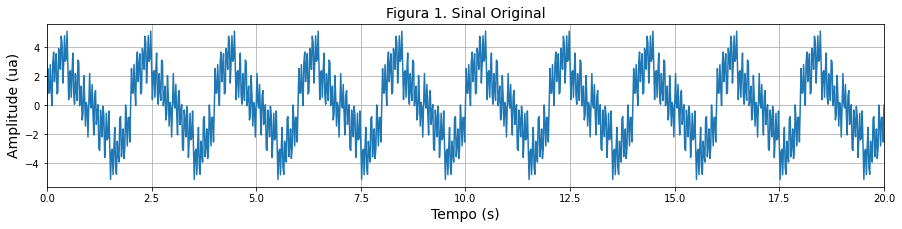

In [4]:
sinal, tempo = gera_sinal([a1, a2, a3, a4, a5], [f1, f2, f3, f4, f5], janela_tempo)
plota_sinal(tempo, sinal, n_figura='1')

# Passo 03 - Mudança de domínio

Perceba que no sinal apresentado na Figura 1 pode-se até identificar a frequência uma ou duas componentes, porém não é possível identificar claramente todas elas. Então como podemos fazer para identificá-las?

Você deve lembrar-se de que qualquer sinal periódico pode ser representado por uma função caracterizada por um somatório de funções senos e cossenos, denominada Série de Fourier. Ora, se podemos representar qualquer sinal por uma série de funções senos e cossenos, então podemos saber quais são as frequências de cada uma destas funções já que cada uma delas tem uma frequência bem definida. Isto pode ser feito realizando-se a *mudança de domínio* do dado, i.e., podemos trabalhar matematicamente o dado para ver características que não conseguimos ver no domínio em que o dado foi registrado.

Existem diversas ferramentas para isto dependendo do que se queira analisar no dado, porém aqui iremos trabalhar a ferramenta denominada **Transformada de Fourier**. Ela nos permitirá tirar o dado do *domínio do tempo* em que foi registrado e representá-lo no *domínio da frequência*. Em outras palavras, ela nos dá o poder de visualizar as componentes de frequência que compõem o sinal. Matematicamente ela é dada por

$$Y(f) = \int_{-\infty}^{\infty} y(t) e^{-2 \pi i f t} dt $$

em que a função $y(t)$ é o sinal registrado no domínio do tempo e $Y(f)$ nos dá o *espectro de amplitudes* do sinal, i.e., a amplitude de cada componente de frequência do presente no sinal original. É possível ainda partir de um dado no domínio da frequência e representá-lo no domínio do tempo fazendo a Transformada de Fourier inversa, dada por

$$y(t) = \int_{-\infty}^{\infty} Y(f) e^{2 \pi i f t} df $$

Esta ferramenta é extremamente importante e é a base para o processamento de sinais geofísicos. Ela pode ser aplicada tanto a dados adquiridos no domínio do tempo, como é o caso de um sinal sísmico ou de radar, quanto a dados adquiridos no domínio do espaço, como é o caso de dados adquiridos com os métodos potenciais.

Execute a célula abaixo para visualizar as cinco componentes de frequência do sinal sintético da Figura 1.

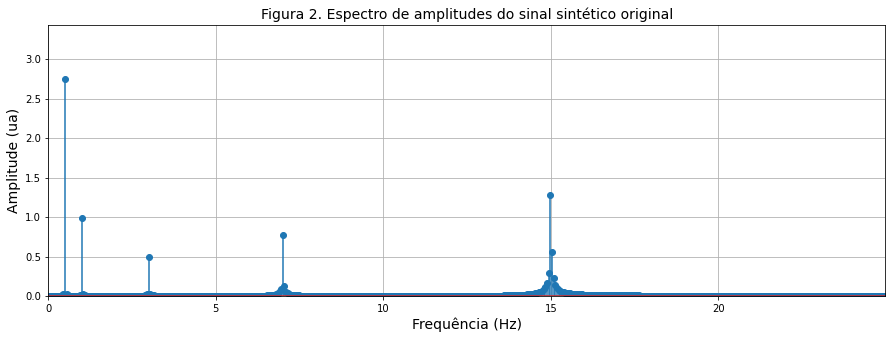

In [5]:
frequencias, amplitude_f = calcula_espectro(tempo, sinal)  # retorna o espectro completo (frequencias positivas e negativas)
plota_espectro(frequencias, amplitude_f, n_figura='2')

**Pergunta:** Todas as frequências e amplitudes mostradas na Figura 2 correspondem às que foram estabelecidas no Passo 02?

# Passo 04 - Filtragem

Vamos agora modificar o sinal da Figura 2 removendo frequências específicas da sua composição e deixando as demais frequências inalteradas. Faremos isso através do processo de **Filtragem**. A filtragem pode ser executada no domínio da frequência através da multiplicação do espectro de amplitude por uma *função caixa* de amplitudes entre 0 e 1, assim aquelas frequências que forem multiplicadas pela amplitude 0 da função caixa serão eliminadas do espectro e as que forem multiplicadas pela amplitude 1 serão mantidas no espectro. Assim, ao realizar a transformada de Fourier inversa, o sinal será recomposto sem as componentes de frequência eliminadas.

Existem quatro tipos de filtros:
* **filtro passa-baixa**: em que é definida uma frequência de corte ($fc$) a partir da qual todas as componentes de frequência são eliminadas;
* **filtro passa-alta**: em que é definida uma frequência de corte ($fc$) a partir da qual todas as componentes de frequência são mantidas;
* **filtro passa-banda**: em que são definidas duas frequências de corte ($fc_1$ e $fc_2$) e todas as componentes de frequência entre elas são mantidas;
* **filtro rejeita-banda**: em que são definidas duas frequências de corte ($fc_1$ e $fc_2$) e todas as componentes de frequência entre elas são eliminadas;

Vamos verificar como estes filtros afetam nosso sinal sintético. Primeiramente vamos configurar a função caixa de um filtro do tipo passa-banda em que serão mantidas as componentes do espectro entre as frequências de corte 5.0 Hz e 20.0Hz. Execute a célula abaixo para configurá-lo, sem modificar nada por enquanto.

In [6]:
tipo = 'passa-banda'      # tipo de filtro a ser aplicado
f_corte = [5.0, 20.0]     # frequências de corte, em Hz (SEMPRE entre colchetes e separadas por vírgula se necessário)

verifica_filtro(f_corte, tipo)

Agora vamos ver como isto afeta o dado. Execute a célula abaixo para visualizar o espectro do dado e a função caixa que acabou de ser configurada e como ficaria o espectro de amplitudes após sua multiplicação por esta função, i.e., após a filtragem.

**Obs.**: A amplitude da função caixa é apresentada aqui com amplitude maior do que 1. Isto é intencional e foi feito para que o topo da caixa fique acima de todas as componentes de frequência do espectro, para facilitar a compreensão da visualização. Nos cálculos a função caixa continua tendo amplitude máxima igual a 1.

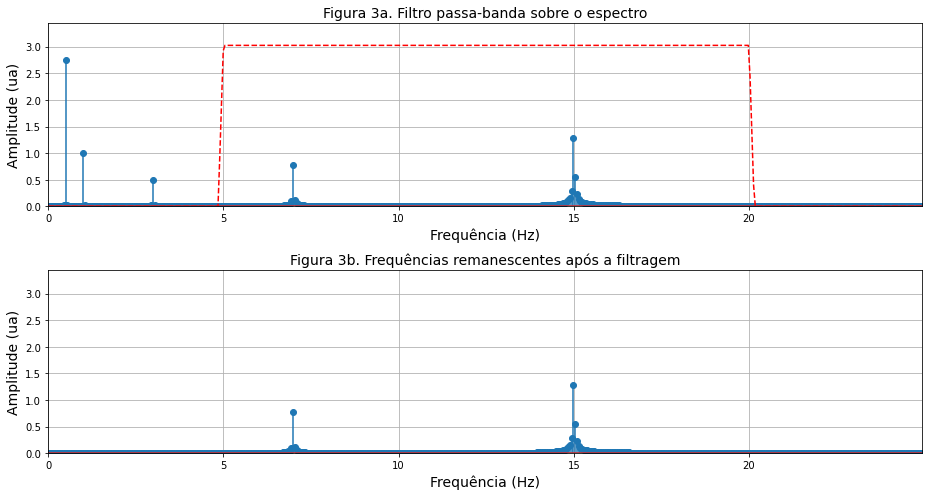

In [7]:
plota_filtragem(amplitude_f, frequencias, f_corte, tipo, n_figura='3')

**Pergunta**: Houve alteração na amplitude ou na frequência de cada componente remanescente?

Por fim, vamos verificar como ficou o sinal filtrado, após removermos as demais componentes. Execute a célula abaixo para visualizar o dado após a transformada de Fourier inversa do espectro da Figura 3b.

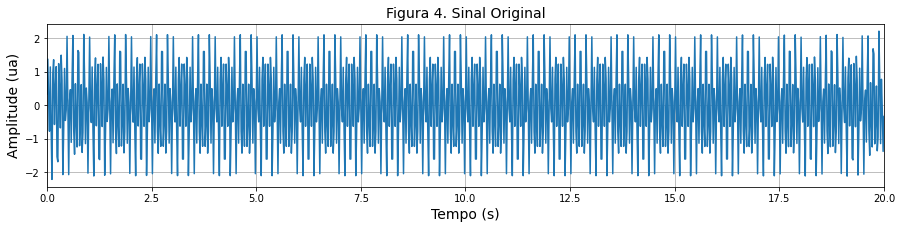

In [8]:
sinal_filtrado = executa_filtragem(amplitude_f, f_corte, tipo)
plota_sinal(tempo, sinal_filtrado, n_figura='4')

# Exercícios - Parte 01

**Instruções gerais**: Você pode definir qualquer um dos quatro tipos de filtro e definir quaisquer frequências de corte, e houver algum erro ao deinir estes parâmetros uma mensagem de erro irá aparecer assim que você executar a célula. Quando for definir as frequências de corte lembre-se de que os filtros **passa-baixa** e **passa-alta** requerem apenas uma frequência, enquanto os filtros **passa-banda** e **rejeita-banda** requerem duas frequências, informadas em ordem crescente. Sempre que for defini-las coloque os números entre colchetes, mesmo que seja definida uma única frequência. Se forem definidas duas frequências, informe-as separadas por vírgula.

1- O filtro passa-banda definido na primeira célula do Passo 04 pode ser substituído por um outro filtro de forma que tenhamos exatamente o mesmo resultado. Qual é este filtro? Modifique os parâmetros de frequência de corte e tipo de filtro na primeira célula do Passo 04 para verificar sua resposta.

2- Modifique os parâmetros de tipo de filtro e frequência de corte na primeira célula do Passo 04 para remover as frequências de 7.0 Hz e de 15.0 Hz. Faça isso utilizando dois filtros diferentes.

3- Tente definir filtros para manter apenas uma componente de frequência no sinal. Verifique se a frequência observada no domínio do tempo corresponde à frequência da componente no espectro de amplitudes. Faça isso para cada componente separadamente. O que acontece quando você tenta fazer este procedimento para as frequências de 0.5 Hz e 1.0 Hz?

4- Modifique os parâmetros do sinal sintético definidos na primeira célula do passo 02, inserindo os valores de amplitude e frequência que você quiser. Verifique como isso altera o espectro e tente filtrar algumas destas componentes utilizando diferentes configurações de filtro na primeira célula do Passo 04.

5- Este sinal é o mesmo utilizado no exercício sobre amostragem de sinais compostos por mais de uma frequência. Você consegue ver alguma relação entre a filtragem e a taxa de amostragem que foi calculada naquela lição? Você pode executá-la novamente clicando [aqui](https://google.com) (abra em uma nova janela para não perder o trabalho feito aqui).

### IMPORTANTE! Não prossiga até que tenha feito os exercícios acima e compreendido bem como a filtragem funciona. 

# Passo 05 - Filtragem no "mundo real"

Até aqui trabalhamos com um sinal composto por apenas cinco componentes, porém um sinal ou dado geofísico real contém inúmeras componentes de frequência e selecioná-las não é tão simples. Vamos trabalhar agora com um dado real. O sinal que será utilizado é um traço que foi extraído de um perfil de GPR adquirido com antena cuja frequência nominal é de 200 MHz. Não é necessário que você conheça os detalhes teóricos do método agora. O importante neste momento é que você entenda a atuação da filtragem em um dado real, que funciona da mesma forma em qualquer tipo de dado geofísico.

Execute a célula abaixo para carregar este dado e visualizá-lo.

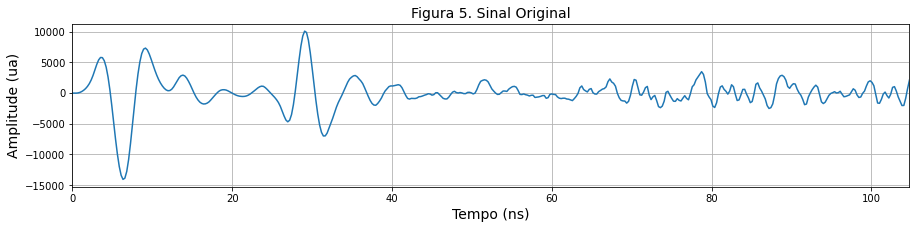

In [9]:
dado_real = np.loadtxt('radar.txt')

tempo = dado_real[:, 0]
sinal_real = dado_real[:, 1]
plota_sinal(tempo, sinal_real, n_figura='5')

A oscilação no início do traço é causada pelo acoplamento entre a antena e o solo. A oscilação entre 20 ns e 40 ns é causada por um objeto enterrado. A oscilação entre 50 ns e 60 ns é causada por um segundo objeto. As oscilações que aparecem após o tempo de 60 ns são decorrentes da perda de energia conforme o pulso eletromagnético se propaga em profundidade no material geológico, que foram levemente realçadas para mostrar a diferença no padrão de oscilações na segunda metade do traço. Você verá isto com calma na disciplina Geofísica II, portanto neste momento apenas tenha em mente que estamos interessados principalmente nas oscilações presentes ente 20 ns e 40 ns e entre 50 ns e 60 ns.

Vamos agora carregar este mesmo traço, porém contaminado por 50 componentes de frequências aleatórias, cada uma com uma amplitude também aleatória. Execute a célula abaixo para visualizar o dado contaminado por estas componentes.

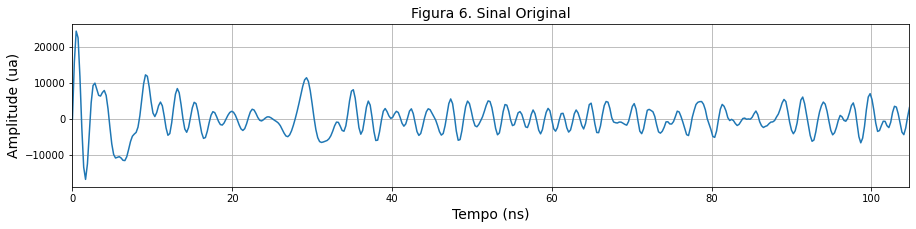

In [10]:
sinal_contaminado = dado_real[:, 2]
plota_sinal(tempo, sinal_contaminado, n_figura='6')

**Pergunta**: Você ainda consegue identificar as oscilações de interesse com a mesma clareza de antes? Consegue perceber padrões de oscilação que se assemelhem a aqueles identificados como sendo de nosso interesse na Figura 5? 

Perceba como os padrões observados no dado sofreram mudanças drásticas em relação à Figura 5. É isto o que o *ruído* faz: ele mascara as informações que nos interessam e, portanto, deve ser removido para que possamos analisar o dado corretamente.

Execute a célula abaixo para visualizar o espectro de amplitudes do sinal contaminado pelo ruído.

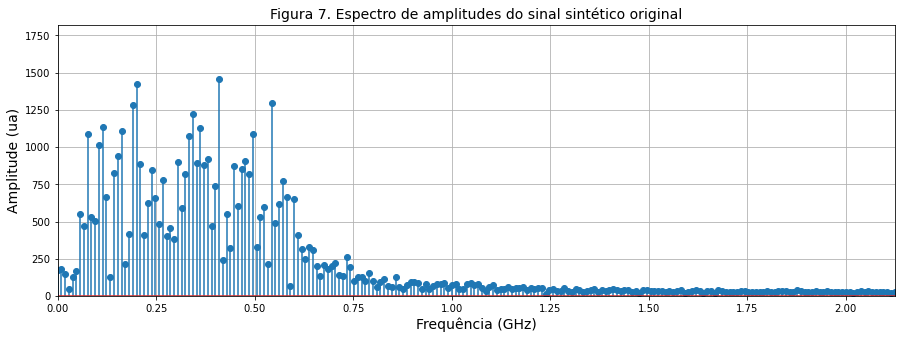

In [11]:
frequencias, amplitude_f = calcula_espectro(tempo, sinal_contaminado)
plota_espectro(frequencias, amplitude_f, n_figura='7')

Assim como fizemos anteriormente no Passo 04, vamos definir um filtro passa-banda para tentarmos eliminar as componentes de frequência que contaminaram o dado. Execute a célula abaixo para definir um filtro passa-banda entre as frequências de 200.0 X 10$^6$ Hz (i.e., 200.0 MHz) e 1.0 X 10$^9$ Hz (i.e., 1.0 GHz).

In [12]:
tipo = 'passa-banda'           # tipo de filtro a ser aplicado
f_corte = [200.0e6, 1.0e9]     # frequências de corte, em Hz (SEMPRE entre colchetes e separadas por vírgula se necessário)

verifica_filtro(f_corte, tipo)

e visualize a localização do filtro sobre o espectro e o efeito da filtragem sobre as componentes de frequência executando a célula abaixo:

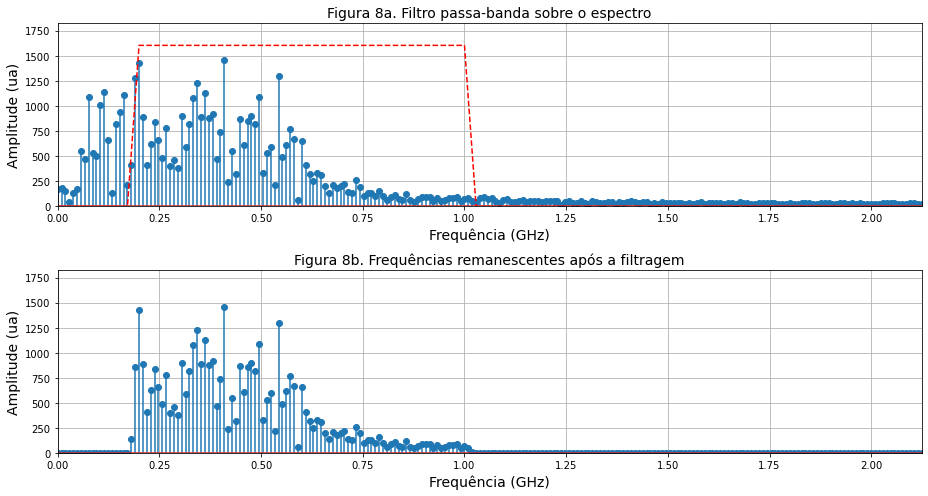

In [13]:
plota_filtragem(amplitude_f, frequencias, f_corte, tipo, n_figura='8')

Por fim, vamos verificar como a remoção das frequências afetou o sinal no domínio do tempo. Executando a célula abaixo para mostrar uma comparação entre o sinal original não contaminado pelas 50 componentes de frequência adicionais (em azul claro) e o sinal após a filtragem configurada acima (em vermelho). Ficaram parecidos?

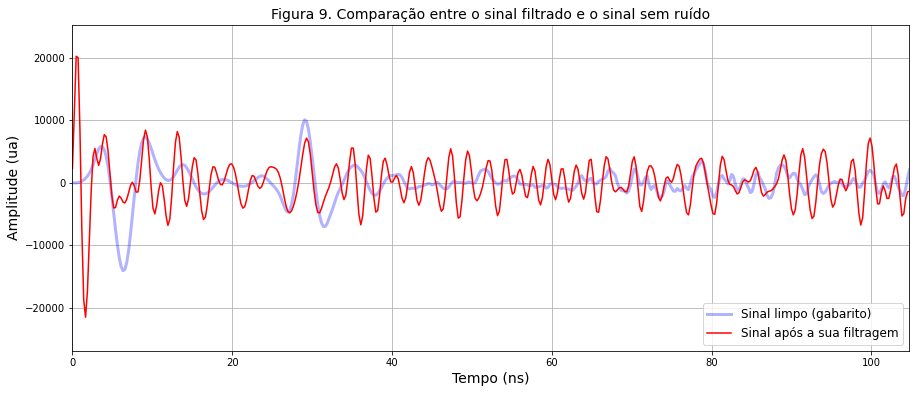

In [14]:
sinal_filtrado = executa_filtragem(amplitude_f, f_corte, tipo)
plota_gabarito(tempo, sinal_filtrado, sinal_real, n_figura='9')

Não, o dado ainda ficou bastante ruim. Isto significa que não removemos as componentes que estão contaminando o sinal. Como podemos saber então quais componentes devemos remover? Como sabemos quais componentes correspondem ao ruído e quais correspondem ao sinal que nos interessa? A resposta é: não sabemos com certeza. Temos apenas algumas dicas de em que região do espectro as componentes que correspondem ao sinal de interesse estão localizadas. Por exemplo, se sabemos que o dado foi adquirido com uma antena cuja frequência nominal é de 200 MHz, podemos começar eliminando as componentes que se distanciem desta região do espectro. Também podemos observar que há uma predominância de componentes de maior amplitude abaixo de 0.75 GHz, então é mais provável que as componentes do nosso sinal estejam abaixo desta frequência, mas ainda assim podemos ter componentes próximas desta região do espectro contribuindo construtivamente para o sinal que nos interessa. A filtragem é um processo de tentativa e erro: elimina-se uma determinada região do espectro e avalia-se a qualidade geral do dado, verificando se a "limpeza" executada permite enxergar o sinal de interesse.

Aqui foi estabelecido previamente que os intervalos entre 20 ns e 40 ns e entre 50 ns e 60 ns correspondem a oscilações de interesse, porém lembre-se de que em uma aquisição de dados geofísicos não se sabe exatamente o que existe em subsuperfície. Por este motivo, se o espectro for alterado de forma muito significativa, pode-se acabar excluindo o sinal de interesse juntamente com o ruído e isto leva a uma interpretação tão errada tanto quanto a interpretação feita a partir do dado não filtrado. Desta forma o processo de filtragem deve ser realizado de forma que se possa melhorar ao máximo a qualidade do dado, porém removendo-se o menor número possível de componentes de frequência para não degradar significativamente o sinal de interesse.


# Exercícios - Parte 02

Volte à quarta célula do Passo 05, onde foram definidos os parâmetros do filtro aplicado sobre o dado real. Modifique estes parâmetros, alterando tanto as frequências de corte quanto o tipo de filtro, e tente eliminar as componentes de ruído que contaminaram o sinal original buscando recuperá-lo da melhor forma possível. Utilize o sinal apresentado em azul claro na Figura 9 como gabarito para avaliar a qualidade da filtragem. Quando for definir as frequências de corte lembre-se de que os filtros **passa-baixa** e **passa-alta** requerem apenas uma frequência, enquanto os filtros **passa-banda** e **rejeita-banda** requerem duas frequências. Sempre que for defini-las coloque os números entre colchetes, mesmo que seja definida uma única frequência. Se forem definidas duas frequências, informe-as separadas por vírgula. Note que aqui o espectro de amplitude é apresentado em GHz e as frequências de corte devem ser informadas em Hz, então aproveite para praticar suas habilidades com a notação científica ao informar estes valores.

### Reflexão

Você diria que a filtragem do dado pode ser considerada uma forma de mascarar a informação para que ela mostre aquilo que você deseja? Por quê?